In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [ ]:
!unzip '/content/drive/MyDrive/Brain_tumor-dataset.zip'

Archive:  /content/drive/MyDrive/Brain_tumor-dataset.zip
  inflating: Testing/glioma_tumor/image(1).jpg  
  inflating: Testing/glioma_tumor/image(10).jpg  
  inflating: Testing/glioma_tumor/image(100).jpg  
  inflating: Testing/glioma_tumor/image(11).jpg  
  inflating: Testing/glioma_tumor/image(12).jpg  
  inflating: Testing/glioma_tumor/image(13).jpg  
  inflating: Testing/glioma_tumor/image(14).jpg  
  inflating: Testing/glioma_tumor/image(15).jpg  
  inflating: Testing/glioma_tumor/image(16).jpg  
  inflating: Testing/glioma_tumor/image(17).jpg  
  inflating: Testing/glioma_tumor/image(18).jpg  
  inflating: Testing/glioma_tumor/image(19).jpg  
  inflating: Testing/glioma_tumor/image(2).jpg  
  inflating: Testing/glioma_tumor/image(20).jpg  
  inflating: Testing/glioma_tumor/image(21).jpg  
  inflating: Testing/glioma_tumor/image(22).jpg  
  inflating: Testing/glioma_tumor/image(23).jpg  
  inflating: Testing/glioma_tumor/image(24).jpg  
  inflating: Testing/glioma_tumor/image(25).

In [ ]:
list(os.listdir(os.curdir))

['.config', 'Training', 'Testing', 'drive', 'sample_data']

In [ ]:
list(os.listdir(os.curdir + "/Training"))

['glioma_tumor', 'pituitary_tumor', 'meningioma_tumor', 'no_tumor']

In [ ]:
list(os.listdir(os.curdir + "/Testing"))

['glioma_tumor', 'pituitary_tumor', 'meningioma_tumor', 'no_tumor']

In [ ]:
labels = ['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']

class_map = {'no_tumor': 0,
             'glioma_tumor': 1,
             'meningioma_tumor': 2,
             'pituitary_tumor': 3}

inverse_class_map = {0: 'no_tumor',
                     1: 'glioma_tumor',
                     2: 'meningioma tumor',
                     3: 'pituitary_tumor'}

In [ ]:
h, w = 224, 224
batch_size = 32
epochs = 100

In [ ]:
from tqdm import tqdm

IMAGE_TRAIN = []
IMAGE_TEST = []
LABELS_TRAIN = []
LABELS_TEST = []

for label in labels:
  folder_path = os.path.join(os.curdir + "/Training", label)
  for j in tqdm(os.listdir(folder_path)):
    img = cv2.imread(os.path.join(folder_path, j))
    img = cv2.resize(img, (h,w))
    IMAGE_TRAIN.append(img)
    LABELS_TRAIN.append(class_map[label])

for label in labels:
  folder_path = os.path.join(os.curdir + "/Testing", label)
  for j in tqdm(os.listdir(folder_path)):
    img = cv2.imread(os.path.join(folder_path, j))
    img = cv2.resize(img, (h,w))
    IMAGE_TEST.append(img)
    LABELS_TEST.append(class_map[label]) 

X_train = np.array(IMAGE_TRAIN)
X_test = np.array(IMAGE_TEST)
y_train = np.array(LABELS_TRAIN)
y_test = np.array(LABELS_TEST)

100%|██████████| 74/74 [00:00<00:00, 131.29it/s]


In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X_train, y_train = shuffle(X_train, y_train, random_state = 2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state = 2)

print(len(X_train), len(X_valid), len(X_test))
print(len(y_train), len(y_valid), len(y_test))

2583 287 394
2583 287 394


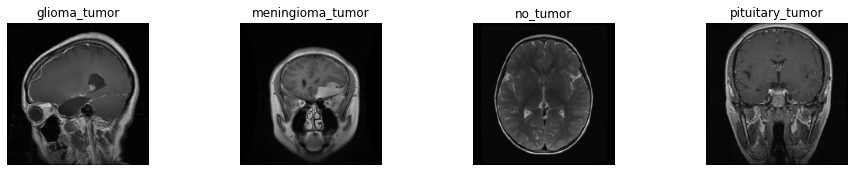

In [ ]:
plt.figure(figsize=(16,12))

path = os.curdir + "/Training/"
fileNames = ['glioma_tumor/gg (101).jpg', 'meningioma_tumor/m (10).jpg', 'no_tumor/image (16).jpg', 'pituitary_tumor/p (43).jpg']
fileLabels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

for i in range(4):
  ax = plt.subplot(4, 4, i+1)
  img = mpimg.imread(path + fileNames[i])
  img = cv2.resize(img, (h,w))
  plt.imshow(img)
  plt.title(fileLabels[i])
  plt.axis("off")


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(
    input_shape = (h,w,3),
    weights = 'imagenet',
    include_top = False,
)

base_model.summary()

87924736/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)           

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Flatten, MaxPooling2D

base_model.trainable = False
output_classes = 4

model = Sequential([
            base_model,
            MaxPooling2D(),
            Dropout(rate=0.6),
            Flatten(),
            Dense(output_classes, activation='softmax')
])

In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate = 0.002)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 2, 2, 2048)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 2, 2, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 4)                 32772     
                                                                 
Total params: 21,835,556
Trainable params: 32,772
Non-trainable params: 21,802,784
_______________________________________

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

early_stop = EarlyStopping(monitor='val_accuracy', 
                           mode='max', 
                           patience=15, 
                           baseline=0.8,
                           verbose = 1)

checkpoint_path = '/tmp/checkpoint'
checkpoint = ModelCheckpoint(filepath = checkpoint_path, 
                             monitor = 'val_accuracy',
                             mode = 'max',
                             verbose = 1)

tensorboard_path = 'logs'
tensorboard = TensorBoard(log_dir = tensorboard_path)

callbacks = [early_stop, checkpoint, tensorboard]

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    rotation_range = 30
    )

In [ ]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size = batch_size),
    validation_data = (X_test, y_test),
    steps_per_epoch = len(X_train)/batch_size,
    epochs = epochs,
    callbacks = callbacks
)

Epoch 1/100
81/80 [==============================] - ETA: 0s - loss: 2.1594 - accuracy: 0.6067
Epoch 00001: saving model to /tmp/checkpoint
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
80/80 [==============================] - 377s 5s/step - loss: 2.1594 - accuracy: 0.6067 - val_loss: 99.5303 - val_accuracy: 0.2716
Epoch 2/100
81/80 [==============================] - ETA: 0s - loss: 1.4182 - accuracy: 0.7096
Epoch 00002: saving model to /tmp/checkpoint
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
80/80 [==============================] - 372s 5s/step - loss: 1.4182 - accuracy: 0.7096 - val_loss: 149.3403 - val_accuracy: 0.2665
Epoch 3/100
81/80 [==============================] - ETA: 0s - loss: 1.2964 - accuracy: 0.7573
Epoch 00003: saving model to /tmp/checkpoint
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
80/80 [==============================] - 371s 5s/step - loss: 1.2964 - accuracy: 0.7573 - val_loss: 168.4736 - val_accuracy: 0.2690
Epoch 4/100

KeyboardInterrupt: ignored

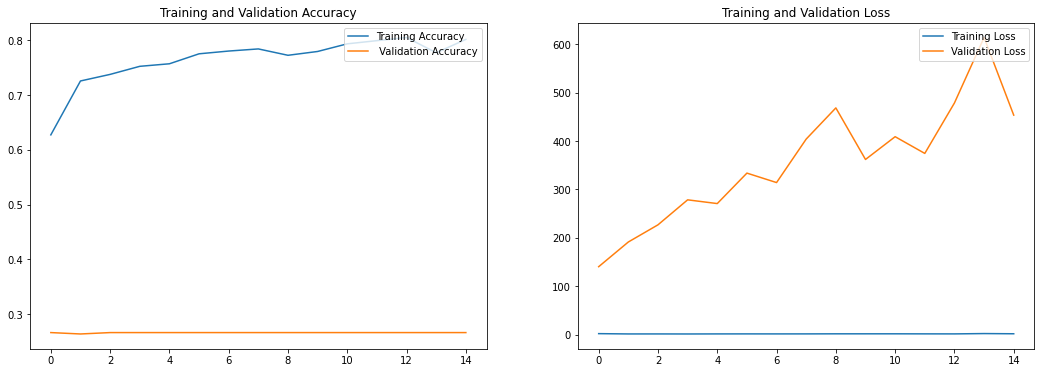

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['accuracy']))

plt.figure(figsize = (18, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label =' Validation Accuracy')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
predicted_labels = model.predict(X_test)
print(predicted_labels[:5])

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [ ]:
predicted_labels = [np.argmax(i) for i in predicted_labels]
print(predicted_labels[:5])

[0, 0, 0, 0, 0]


In [ ]:
original_labels = [np.argmax(i) for i in y_test]
print(original_labels[:5])

[0, 0, 0, 0, 0]


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

conf_mat = confusion_matrix(original_labels, predicted_labels)
report = classification_report(original_labels, predicted_labels)

print("CONFUSION MATRIX")
print(conf_mat)
print("  ")
print("CLASSIFICATION REPORT")
print(report)

CONFUSION MATRIX
[[105   0   0   0]
 [100   0   0   0]
 [115   0   0   0]
 [ 74   0   0   0]]
  
CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.27      1.00      0.42       105
           1       0.00      0.00      0.00       100
           2       0.00      0.00      0.00       115
           3       0.00      0.00      0.00        74

    accuracy                           0.27       394
   macro avg       0.07      0.25      0.11       394
weighted avg       0.07      0.27      0.11       394



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model.save("brain-tumor.h5")